Import Modules

In [1]:
# Data modules
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

# Others
import datetime
from os import path
import requests
import json

# Image modules
from PIL import Image
from wordcloud import WordCloud

# Maps and Location modules
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Math functions
from math import radians, sin, cos, asin, atan2, degrees, sqrt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Modules imported.')

Modules imported.


## Helper Functions

In [2]:
def get_parent_category(venue):
    venue=venue.lower()
    
    # Custom keyword categories
    food_keywords = ['cake', 'cream', 'noodle', 'subway', 'beer', 'taco', 'burrito', 'restaurant']
    professional_place_keywords = ['embassy', 'pharmacy']
    outdoor_place_keywords = ['gym', 'centre', 'center', 'sport', 'massage', 'spa', 'mall']
    place_of_worship_keywords = ['temple', 'church', 'mosque', 'shrine', 'synagogue']
    arts_entertainment_keywords = ['museum', 'planetarium', 'theater']
    travel_transport_keywords = ['rail', 'ferry', 'station', 'car']
    
    # Check Foursquare categories
    for cat in foursquare_categories:
        _cat = cat.lower()
        if (venue in foursquare_categories[cat]) or (venue in _cat):
            return cat
        # generic keywords
        if 'school' in venue:
            return 'College & University'
        if 'neighborhood' in venue or 'city' in venue:
            return 'Residence'
        
    # Check 'Food' items
    for item in food_keywords:
        if item in venue:
            return 'Food'
        
    # Check 'Professional & Other Places' items
    for item in professional_place_keywords:
        if item in venue:
            return 'Professional & Other Places'
        
    # Check 'Outdoors & Recreation' items
    for item in outdoor_place_keywords:
        if item in venue:
            return 'Outdoors & Recreation'
        
    # Check 'Place of Worship' items:
    for item in place_of_worship_keywords:
        if item in venue:
            return 'Place of Worship'
        
    # Check 'Arts & Entertainment':
    for item in arts_entertainment_keywords:
        if item in venue:
            return 'Arts & Entertainment'
        
    # Check 'Travel & Transport' items
    for item in travel_transport_keywords:
        if item in venue:
            return 'Travel & Transport'
    # 'Other'
    return 'Other'

In [3]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
def getTimeCat(strUtcTime):    
    # extract time categories
    _time = datetime.datetime.strptime(strUtcTime, '%a %b %d %H:%M:%S %z %Y')
    ts = _time.time()

    # --> Morning = 0400-1000
    mornStart = datetime.time(4, 0, 1)
    mornEnd = datetime.time(10, 0, 0)

    # --> Midday = 1000-1600
    midStart = datetime.time(10, 0, 1)
    midEnd = datetime.time(16, 0, 0)

    # --> Evening = 1600-2200
    eveStart = datetime.time(16, 0, 1)
    eveEnd = datetime.time(22, 0, 0)

    # --> Late Night = 2200-0400
    lateStart = datetime.time(22, 0, 1)
    lateEnd = datetime.time(4, 0, 0)

    if time_in_range(mornStart, mornEnd, ts):
      timecat = 'Morning'
    elif time_in_range(midStart, midEnd, ts):
      timecat = 'Midday'
    elif time_in_range(eveStart, eveEnd, ts):
      timecat = 'Evening'
    elif time_in_range(lateStart, lateEnd, ts):
      timecat = 'Late Night'

    return timecat

In [4]:
def get_distance_btw_coords(coord_pairs, unit='mi'):
    '''
    description: Returns distance in 'mi' or 'km' between two coordinate points.
    params: coord_pairs (tuple) <- (latitude1, longitude1, latitude2, longitude2) in decimal            
            unit       (str) <- (default: 'mi':miles, else use 'km': kilometers)
    return: distance (float) -> returns distance

    reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth.
    '''
    lat1, lon1, lat2, lon2 = coord_pairs
    #lat1, lon1 = latlon1
    #lat2, lon2 = latlon2
    # First, convert the latitude and longitude values from decimal degrees to radians.
    lat1, lon1, lat2, lon2 = tuple(map(radians, (lat1, lon1, lat2, lon2)))

    # If we want to calculate the distance between two places in miles,
    # use the value '3,958.756', which is the radius of Earth; use '6,371' for kilometers (from Google).
    earth_radius = 3958.756 if unit.lower() == 'mi' else 6371

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    dist_rad = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    dist = 2 * asin(sqrt(dist_rad))

    # Return result
    return dist*earth_radius


def get_center_coords(coords_list):
    '''
    description: Returns the 'geographic midpoint' is calculated by finding the center of gravity
                 for the locations in the 'coordinate' list.
    params: coords_list (list) <- [(latitude, longitude), (latitude, longitude), ... ]; coordinates in decimal              
    return: coordinate (tuple) -> returns (latitude, longitude)

    reference: http://www.geomidpoint.com/calculation.html
    '''
    total_weight = len(coords_list)

    # Step 1: Convert coordinates to radians
    coords_list_radians = [(radians(x), radians(y)) for x, y in coords_list]

    # Step 2: Convert lat/lon to Cartesian coordinates viz: x,y,z
    #           X = cos(lat1) * cos(lon1)
    #           Y = cos(lat1) * sin(lon1)
    #           Z = sin(lat1)
    cartesian_coords_list = [(cos(lat) * cos(lon), cos(lat) * sin(lon), sin(lat))  # (X,Y,Z) tuple as described above
                             for lat, lon in coords_list_radians]

    # Step 3: Compute weighted average x, y and z coordinates
    x = np.average(
        np.asarray(list(_x for _x, _, _ in cartesian_coords_list)))/total_weight
    y = np.average(
        np.asarray(list(_y for _, _y, _ in cartesian_coords_list)))/total_weight
    z = np.average(
        np.asarray(list(_z for _, _, _z in cartesian_coords_list)))/total_weight

    # Step 4: Convert average x, y, z coordinate to latitude and longitude.
    _lon = atan2(y, x)
    _hyp = sqrt(x * x + y * y)
    _lat = atan2(z, _hyp)

    # Step 5: Convert lat and lon to degrees.
    lat = degrees(_lat)
    lon = degrees(_lon)

    # Return result
    return lat, lon


In [5]:
def flatten_coords_list(coords_list):
    '''
    description: recursively flatten list by iterating inner lists and returning coordinates tuples
    param: coords_list (list) <- list (of list ...) of coordinates
    returns: coords_list (list) -> single list of tuples(lat,lon)
    '''
    result = []
    if isinstance(coords_list, list):
        if (len(coords_list) == 2
            and isinstance(coords_list[0], float)
                and isinstance(coords_list[1], float)):
            return [tuple(coords_list)]
        if len(coords_list) > 0:
            for item in coords_list:
                result += flatten_coords_list(item)
            return result
    return coords_list

In [6]:
def get_normalized_coords(coords_list, reverse_latlon_order=False):
    '''
    description: Calculates the geographic midpoint from the list of coordinates
    params: (list) <- coords_list : list of tuples - [(lat,lon), ...]
    returns: (float, float) -> tuple of coordinates
    '''
    flattened_list = flatten_coords_list(coords_list)
    if reverse_latlon_order:
        flattened_list = [(y,x) for x,y in flattened_list]
    lat, lon = get_center_coords(flattened_list)
    return lat,lon

In [7]:
# Generate NYC Regions csv and put it in cache, return dataframe
def generate_nyc_regions():
    '''
    description: Generate NYC Regions csv and put it in cache
    return: DataFrame
    '''
    nyc_geojson_file = r'data/nyu_2451_34572-geojson.json'
    nyc_regions_csv = r'cache/nyc_regions.csv'
    # If file doen's exist, cache it for later use
    if not path.isfile(nyc_regions_csv):
        with open(nyc_geojson_file) as f:
            nyc_geojson = json.load(f)
            
        # define the dataframe columns
        column_names = ['Area', 'Neighborhood', 'Latitude', 'Longitude'] 

        # instantiate the dataframe
        neighborhoods = pd.DataFrame(columns=column_names)
        for data in nyc_geojson['features']:
            borough = data['properties']['borough'] 
            neighborhood_name = data['properties']['name']

            neighborhood_latlon = data['geometry']['coordinates']
            neighborhood_lat = neighborhood_latlon[1]
            neighborhood_lon = neighborhood_latlon[0]

            neighborhoods = neighborhoods.append({'Area': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)
        
        # Cache to a file
        neighborhoods.to_csv(nyc_regions_csv, index=False)
        print('Created {}'.format(nyc_regions_csv))
    
    # Return dataframe
    return pd.read_csv(nyc_regions_csv)


# Generate TYO Regions csv and put it in cache, return dataframe
def generate_tyo_regions():
    '''
    description: # Generate TYO Regions csv and put it in cache
    return: DataFrame
    '''
    tyo_geojson_file = r'data/tokyo.geojson'
    tyo_regions_csv = r'cache/tyo_regions.csv'
    # If file doen's exist, cache it for later use
    if not path.isfile(tyo_regions_csv):
        with open(tyo_geojson_file) as f:
            tyo_geojson = json.load(f)
            
        # define the dataframe columns
        column_names = ['Area', 'Neighborhood', 'Latitude', 'Longitude'] 

        # instantiate the dataframe
        neighborhoods = pd.DataFrame(columns=column_names)
        for item in tyo_geojson['features']:
            area, ward, coords_list = (item['properties']['area_en']
                       ,item['properties']['ward_en']
                       ,item['geometry']['coordinates'])
            if area and ward and coords_list:
                lat, lon = get_normalized_coords(coords_list, reverse_latlon_order=True)
                neighborhoods = neighborhoods.append({'Area': area,
                                                      'Neighborhood': ward,
                                                      'Latitude': lat,
                                                      'Longitude': lon}, ignore_index=True)
            else:
                # Skip unavailable data
                pass
            
        
        # Cache to a file
        neighborhoods.to_csv(tyo_regions_csv, index=False)
        print('Created {}'.format(tyo_regions_csv))
    
    # Return dataframe
    return pd.read_csv(tyo_regions_csv)

## Data Preprocessing

#### Define Category Type

In [ ]:
# !!!! REMOVE !!!!
CLIENT_ID = '<REMOVED>' # your Foursquare ID
CLIENT_SECRET = '<REMOVED>' # your Foursquare Secret
VERSION = '20200525' # Foursquare API version

In [ ]:
# Fetch Foursquare categories
endpoint = 'https://api.foursquare.com/v2/venues/categories'

params = dict(
client_id=CLIENT_ID,
client_secret=CLIENT_SECRET,
v=VERSION
)

# Hit endpoint
response = (requests.get(endpoint, params=params)).json()

# Categories Dictionary
foursquare_categories = {}
for parent_cat in response['response']['categories']:
    foursquare_categories[parent_cat['name']]=set()
    for cat in parent_cat['categories']:
        foursquare_categories[parent_cat['name']].add(cat['name'].lower().strip())
    

### Clean DataSets
Use the cached final dataset as following section is **computationally intensive**.   
`See `**Cached Dataset**` section below`

In [ ]:
# Datasets
nyc_csv = r"data/dataset_TSMC2014_NYC.csv"
tky_csv = r"data/dataset_TSMC2014_TKY.csv"

In [ ]:
nyc = pd.read_csv(nyc_csv)
tky = pd.read_csv(tky_csv)

In [ ]:
nyc_neighborhoods = generate_nyc_regions()
neighborhood_df = nyc_neighborhoods[['Latitude','Longitude']]
def get_region_csv_str(lat, lon):
    latlon_series = neighborhood_df.apply(lambda x: (x['Latitude'], x['Longitude'], lat,lon), axis=1)
    res = latlon_series.apply(get_distance_btw_coords)
    # Get row which is closest w.r.t distance
    idx=res.idxmin()    
    row = nyc_neighborhoods.iloc[idx:idx+1,]
    # Return only area and neighborhood
    return row.values.tolist()[0][:2]

In [ ]:
nyc['RegionInfo'] = nyc.apply(lambda _df: get_region_csv_str(_df['latitude'], _df['longitude']), axis=1)

In [ ]:
# Merge Columns
nyc_1=nyc[list(nyc.columns[:-1])]
nyc_2=nyc[list(nyc.columns[-1:])]
nyc_2 = pd.DataFrame(list(nyc_2['RegionInfo']),
                                 columns = list(nyc_neighborhoods.columns[:2]))
nyc = pd.concat([nyc_1, nyc_2], axis=1)

In [ ]:
nyc.to_csv('cache/nyc.csv', index=False)

In [ ]:
tyo_neigborhoods = generate_tyo_regions()
neighborhood_df = tyo_neigborhoods[['Latitude','Longitude']]
def get_region_csv_str(lat, lon):
    latlon_series = neighborhood_df.apply(lambda x: (x['Latitude'], x['Longitude'], lat,lon), axis=1)
    res = latlon_series.apply(get_distance_btw_coords)
    # Get row which is closest w.r.t distance
    idx=res.idxmin()    
    row = tyo_neigborhoods.iloc[idx:idx+1,]
    # Return only area and neighborhood
    return row.values.tolist()[0][:2]

In [ ]:
tky['RegionInfo'] = tky.apply(lambda _df: get_region_csv_str(_df['latitude'], _df['longitude']), axis=1)

In [ ]:
# Merge Columns
tky_1=tky[list(tky.columns[:-1])]
tky_2=tky[list(tky.columns[-1:])]
tky_2 = pd.DataFrame(list(tky_2['RegionInfo']),
                                 columns = list(tyo_neigborhoods.columns[:2]))
tky = pd.concat([tky_1, tky_2], axis=1)

In [ ]:
tky.to_csv('cache/tky.csv', index=False)

In [ ]:
# Add cityCode column
nyc['cityCode'] = 'NYC'
tky['cityCode'] = 'TYO'

In [ ]:
# Stack the DataFrames on top of each other
df = pd.concat([nyc, tky], axis=0)

In [ ]:
# Rename columns
df.rename(columns={'utcTimestamp':'checkInUtcTimestamp', 'Area':'area', 'Neighborhood':'neighborhood'}
          , inplace=True)

In [ ]:
# Drop venueId and venueCategoryId (since we already have coordinates and venueName)
# Drop timezoneOffset (since the comparison will be in relative time per city)
df.drop(columns=['timezoneOffset','venueId', 'venueCategoryId'], inplace=True)

In [ ]:
# Add 'Venue Type' column
df['venueType'] = df['venueCategory'].apply(get_parent_category)

In [ ]:
# Add 'timeCategory' representing: morning, midday, evening, and late night
df['timeCategory'] = df['checkInUtcTimestamp'].apply(getTimeCat)

In [9]:
# Add natural order to 'timeCategory'
df['timeCategory']=df['timeCategory'].astype(CategoricalDtype(categories=['Morning','Midday','Evening','Late Night']
                                           ,ordered=True))

In [ ]:
# Rearrange columns
rearrangedCols = ['userId', 'cityCode', 'area', 'neighborhood',
                  'venueType', 'venueCategory',
                  'timeCategory', 'checkInUtcTimestamp',
                  'latitude', 'longitude']
df = df[rearrangedCols]

In [ ]:
df.head()

In [ ]:
df.tail()

#### Save updated dataset 
_Double click for code_
<!--df.to_csv('cache/df.csv', index=False)-->

## `Cached Dataset`

In [8]:
# Use cached copies of updated datasets to avoid re-running. 
df_csv = r"cache/df.csv"
df = pd.read_csv(df_csv)

In [10]:
print(df.shape)

(801131, 10)


In [11]:
df.head()

,userId,cityCode,area,neighborhood,venueType,venueCategory,timeCategory,checkInUtcTimestamp,latitude,longitude
0,470,NYC,Manhattan,Soho,Shop & Service,Arts & Crafts Store,Evening,Tue Apr 03 18:00:09 +0000 2012,40.719810,-74.002581
1,979,NYC,Brooklyn,Fort Hamilton,Outdoors & Recreation,Bridge,Evening,Tue Apr 03 18:00:25 +0000 2012,40.606800,-74.044170
2,69,NYC,Queens,Middle Village,Residence,Home (private),Evening,Tue Apr 03 18:02:24 +0000 2012,40.716162,-73.883070
3,395,NYC,Manhattan,Murray Hill,Professional & Other Places,Medical Center,Evening,Tue Apr 03 18:02:41 +0000 2012,40.745164,-73.982519
4,87,NYC,Manhattan,Flatiron,Food,Food Truck,Evening,Tue Apr 03 18:03:00 +0000 2012,40.740104,-73.989658


In [12]:
df.tail()

,userId,cityCode,area,neighborhood,venueType,venueCategory,timeCategory,checkInUtcTimestamp,latitude,longitude
801126,326,TYO,Tokubu,Shibuya Ku,Arts & Entertainment,Music Venue,Late Night,Sat Feb 16 02:34:35 +0000 2013,35.656939,139.702518
801127,853,TYO,Tokubu,Itabashi Ku,Travel & Transport,Train Station,Late Night,Sat Feb 16 02:34:53 +0000 2013,35.858740,139.657286
801128,1502,TYO,Tokubu,Chiyoda Ku,Food,Tea Room,Late Night,Sat Feb 16 02:34:55 +0000 2013,35.701748,139.771216
801129,408,TYO,Tokubu,Chuo Ku,Food,Fast Food Restaurant,Late Night,Sat Feb 16 02:35:17 +0000 2013,35.670465,139.768348
801130,1050,TYO,Tama,Musashino Shi,Shop & Service,Record Shop,Late Night,Sat Feb 16 02:35:29 +0000 2013,35.704069,139.579496


In [13]:
# Create City Masks for filtering
nyc = df['cityCode']=='NYC'
tyo = df['cityCode']=='TYO'

## Visualization

#### _Word Clouds_

In [14]:
wordcloud = WordCloud(background_color='white', width=800, height=400)

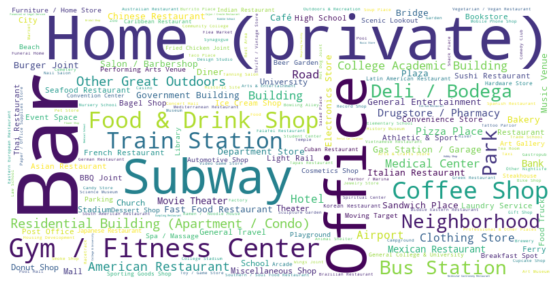

In [15]:
# NYC Venue Categories
nyc_word_cloud = wordcloud.generate_from_frequencies(df[nyc].groupby('venueCategory').size().to_dict())
plt.figure(figsize=(10,5))
plt.imshow(nyc_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/NYC_Venue_Categories.png')
plt.show()

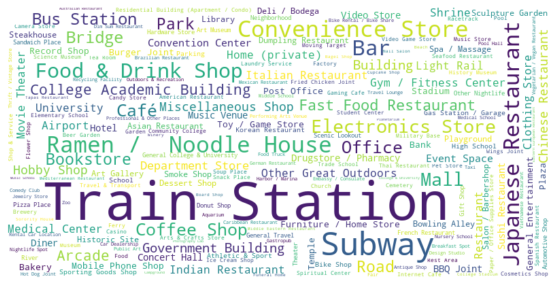

In [16]:
# TKY Venue Categories
tyo_word_cloud = wordcloud.generate_from_frequencies(df[tyo].groupby('venueCategory').size().to_dict())
plt.figure(figsize=(10,5))
plt.imshow(tyo_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/TYO_Venue_Categories.png')
plt.show()

#### _Venue Types_ Distribution

In [17]:
# Venue Types
nyc_venue_types = df[nyc].groupby('venueType').size()
tyo_venue_types = df[tyo].groupby('venueType').size()

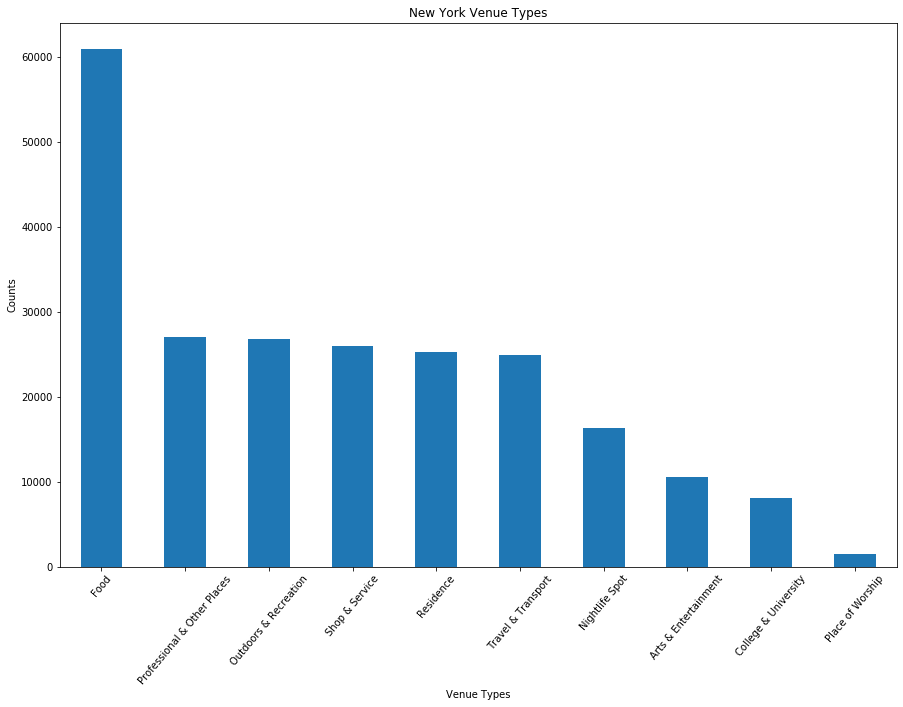

In [18]:
# NYC Venue Types
plt.figure(figsize=(15,10))
nyc_venue_types.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel('Venue Types')
plt.ylabel('Counts')
plt.title('New York Venue Types')
plt.savefig('img/NYC_Venue_Types.png')
plt.show()

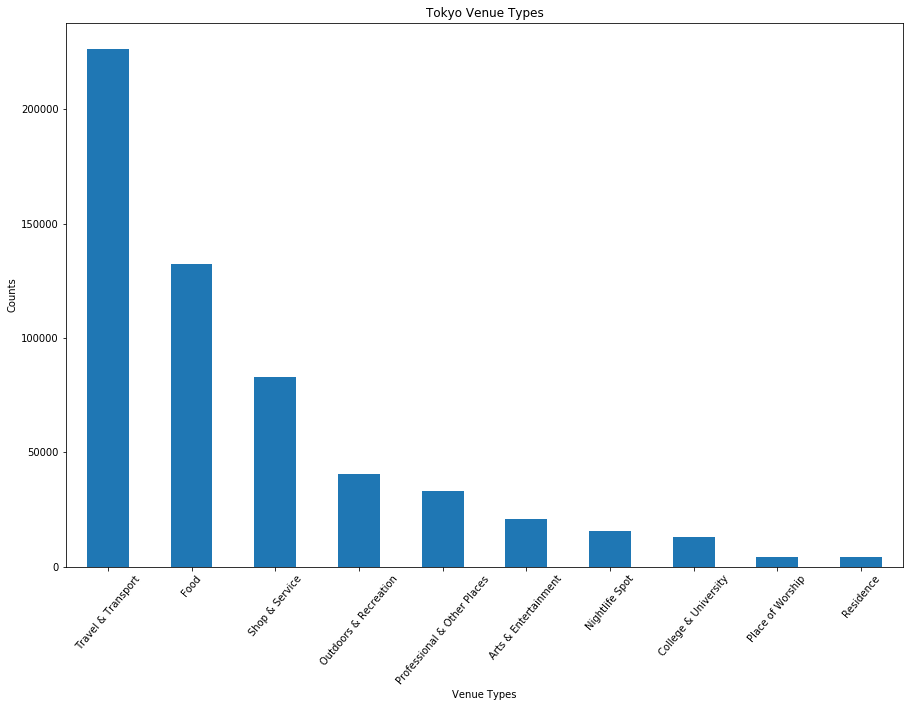

In [19]:
# TKY Venue Types
plt.figure(figsize=(15,10))
tyo_venue_types.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel('Venue Types')
plt.ylabel('Counts')
plt.title('Tokyo Venue Types')
plt.savefig('img/TYO_Venue_Types.png')
plt.show()

#### _Time of the Day_ Distribution

In [20]:
# Venue Types
nyc_timeCategories = df[nyc].groupby('timeCategory').size()
tyo_timeCategories = df[tyo].groupby('timeCategory').size()

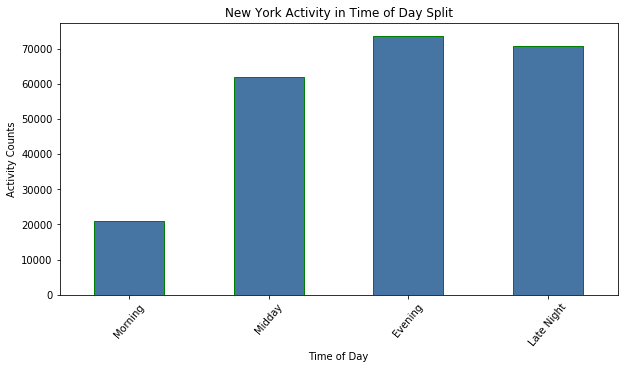

In [21]:
# NYC Venue Types
plt.figure(figsize=(10,5))
nyc_timeCategories.plot.bar(color=(0.2, 0.4, 0.6, 0.9),  edgecolor='green')
plt.xticks(rotation=50)
plt.xlabel('Time of Day')
plt.ylabel('Activity Counts')
plt.title('New York Activity in Time of Day Split')
plt.savefig('img/NYC_TimeCategory.png')
plt.show()

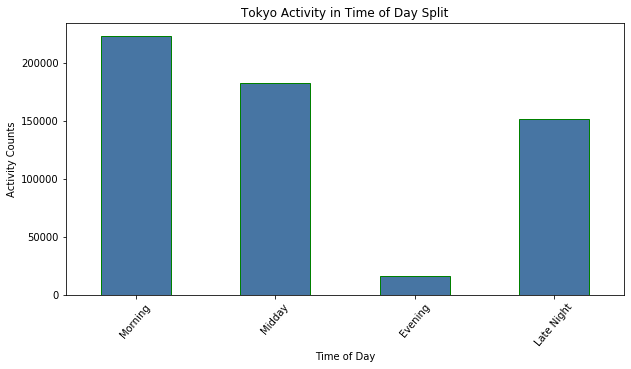

In [22]:
# TYO Venue Types
plt.figure(figsize=(10,5))
tyo_timeCategories.plot.bar(color=(0.2, 0.4, 0.6, 0.9),  edgecolor='green')
plt.xticks(rotation=50)
plt.xlabel('Time of Day')
plt.ylabel('Activity Counts')
plt.title('Tokyo Activity in Time of Day Split')
plt.savefig('img/TYO_TimeCategory.png')
plt.show()

### `Neighborhoods` Visualization

In [23]:
# Geo Locator
geolocator = Nominatim(user_agent="city_explorer")
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        latlon = location.latitude, location.longitude
        # Print results
        print('The geograpical coordinate of "{}" are ({}, {}).'.format(address,*latlon))
        return latlon    
    except:
        print('ERROR: "{}" not found).'.format(address))
        return (-1,-1)

In [24]:
# Save latitude and longitude
nyc_latlon = get_coordinates('New York City, NY')
tyo_latlon = get_coordinates('Tokyo, Japan')

The geograpical coordinate of "New York City, NY" are (40.7127281, -74.0060152).
The geograpical coordinate of "Tokyo, Japan" are (35.6828387, 139.7594549).


In [25]:
nyc_neigborhoods = generate_nyc_regions()
tyo_neigborhoods = generate_tyo_regions()

In [26]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=nyc_latlon, zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neigborhoods['Latitude']
                                           , nyc_neigborhoods['Longitude']
                                           , nyc_neigborhoods['Area']
                                           , nyc_neigborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(        
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [27]:
# create map of Tokyo using latitude and longitude values
map_tokyo = folium.Map(location=tyo_latlon, zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tyo_neigborhoods['Latitude']
                                           , tyo_neigborhoods['Longitude']
                                           , tyo_neigborhoods['Area']
                                           , tyo_neigborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(        
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
map_tokyo

#### Choose Area

Let's find out the largest areas in both cities based on checkin counts.

In [28]:
# Largest Checkins in NYC
nyc_area_wise_checkin_count = df[nyc].groupby('area').count()
max_count_idx = nyc_area_wise_checkin_count['userId'].idxmax()
nyc_area_wise_checkin_count[nyc_area_wise_checkin_count.index==max_count_idx][['userId','cityCode']]

,userId,cityCode
area,,
Manhattan,134950,134950


In [29]:
# Largest Checkins in TYO
tyo_area_wise_checkin_count = df[tyo].groupby('area').count()
max_count_idx = tyo_area_wise_checkin_count['userId'].idxmax()
tyo_area_wise_checkin_count[tyo_area_wise_checkin_count.index==max_count_idx][['userId','cityCode']]

,userId,cityCode
area,,
Tokubu,516040,516040


In [30]:
# Get Toushobu coordinates
toushobu_coords = get_coordinates('Toushobu, Japan')

ERROR: "Toushobu, Japan" not found).


Hmm.. seems like the geojson of Tokyo has some name issues (probably in returning english name of wards). After checking one of the coordinates on google, the area is Kanto Region of Tokyo in Japan.

In [31]:
# Get Kanto coordinates
kanto_coords = get_coordinates('Tokyo, Kanto')

The geograpical coordinate of "Tokyo, Kanto" are (35.7476556, 139.3403339).


The coordinates returned are comparable. Let's replace Tokubu with Kanto.

In [32]:
df_kanto = df[tyo][df[tyo]['area']=='Tokubu'].copy()
df_kanto['area'] = 'Kanto'

In [33]:
tyo_neigborhoods.replace(to_replace ="Tokubu", 
                 value ="Kanto", inplace=True) 

## Manhattan

In [34]:
# Get Manhattan coordinates
manhattan_coords = get_coordinates('Manhattan, NY')

The geograpical coordinate of "Manhattan, NY" are (40.7896239, -73.9598939).


In [35]:
# Filter on 'Manhattan'
manhattan_data = nyc_neigborhoods[nyc_neigborhoods['Area'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Area,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [36]:
def get_map(latlon, df, zoom=10):
    
    map_result = folium.Map(location=latlon, zoom_start=zoom)

    # add markers to map
    for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_result)  

    return map_result

In [37]:
get_map(manhattan_coords, manhattan_data, zoom=11)

#### Analyze

In [38]:
manhattan_venues = df[nyc][df[nyc]['area']=='Manhattan']

In [39]:
print(manhattan_venues.shape)
manhattan_venues.head()

(134950, 10)


,userId,cityCode,area,neighborhood,venueType,venueCategory,timeCategory,checkInUtcTimestamp,latitude,longitude
0,470,NYC,Manhattan,Soho,Shop & Service,Arts & Crafts Store,Evening,Tue Apr 03 18:00:09 +0000 2012,40.719810,-74.002581
3,395,NYC,Manhattan,Murray Hill,Professional & Other Places,Medical Center,Evening,Tue Apr 03 18:02:41 +0000 2012,40.745164,-73.982519
4,87,NYC,Manhattan,Flatiron,Food,Food Truck,Evening,Tue Apr 03 18:03:00 +0000 2012,40.740104,-73.989658
6,642,NYC,Manhattan,Murray Hill,Food,Coffee Shop,Evening,Tue Apr 03 18:04:38 +0000 2012,40.751591,-73.974121
7,292,NYC,Manhattan,Carnegie Hill,Travel & Transport,Bus Station,Evening,Tue Apr 03 18:04:42 +0000 2012,40.779422,-73.955341


In [40]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['venueType']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['neighborhood'] = manhattan_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Place of Worship,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Soho,0,0,0,0,0,0,0,0,1,0
3,Murray Hill,0,0,0,0,0,0,1,0,0,0
4,Flatiron,0,0,1,0,0,0,0,0,0,0
6,Murray Hill,0,0,1,0,0,0,0,0,0,0
7,Carnegie Hill,0,0,0,0,0,0,0,0,0,1


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
manhattan_grouped = manhattan_onehot.groupby('neighborhood').mean().reset_index()
manhattan_grouped

,neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Place of Worship,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Battery Park City,0.039303,0.043177,0.213396,0.053418,0.146969,0.006643,0.153058,0.070302,0.060614,0.213119
1,Carnegie Hill,0.046951,0.026983,0.357258,0.066919,0.126282,0.005397,0.093902,0.056665,0.198057,0.021587
2,Central Harlem,0.041945,0.001824,0.241945,0.012158,0.168997,0.038906,0.067477,0.130091,0.082067,0.214590
3,Chelsea,0.057722,0.021148,0.297452,0.160686,0.108338,0.001213,0.150286,0.041428,0.101404,0.060322
4,Chinatown,0.034091,0.010490,0.519231,0.127622,0.094406,0.000000,0.061189,0.058566,0.056818,0.037587
5,Civic Center,0.024911,0.110913,0.294187,0.054567,0.119217,0.002966,0.234875,0.055753,0.060498,0.042112
6,Clinton,0.105516,0.000356,0.300178,0.195730,0.026690,0.001423,0.073132,0.060320,0.043594,0.193060
7,East Harlem,0.025502,0.042865,0.243625,0.035811,0.132935,0.003798,0.116115,0.228974,0.139447,0.030928
8,East Village,0.088265,0.002296,0.451020,0.273469,0.038265,0.000255,0.023980,0.046173,0.068112,0.008163
9,Financial District,0.020452,0.026103,0.320775,0.053552,0.116254,0.002691,0.290097,0.030678,0.066469,0.072928


In [42]:
manhattan_grouped.shape

(40, 11)

In [43]:
neighborhoods_venues_sorted = manhattan_grouped.copy()

Run *k*-means to cluster the neighborhood into 10 clusters.

In [44]:
# set number of clusters
kclusters = 10

manhattan_grouped_clustering = manhattan_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([8, 0, 8, 9, 3, 1, 3, 4, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Area,Neighborhood,Latitude,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Place of Worship,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Manhattan,Marble Hill,40.876551,-73.910660,0,0.006452,0.009677,0.358065,0.000000,0.141935,0.000000,0.048387,0.125806,0.183871,0.125806
1,Manhattan,Chinatown,40.715618,-73.994279,3,0.034091,0.010490,0.519231,0.127622,0.094406,0.000000,0.061189,0.058566,0.056818,0.037587
2,Manhattan,Washington Heights,40.851903,-73.936900,4,0.030382,0.060764,0.189351,0.025472,0.144392,0.010281,0.119687,0.149302,0.183367,0.087003
3,Manhattan,Inwood,40.867684,-73.921210,2,0.019704,0.002956,0.309360,0.069951,0.119212,0.014778,0.090640,0.218719,0.138916,0.015764
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,0.083895,0.050169,0.319562,0.009696,0.108347,0.011383,0.043002,0.225126,0.088111,0.060708


In [46]:
manhattan_merged.shape

(40, 15)

Finally, let's visualize the resulting clusters

In [47]:
# create map
map_clusters = folium.Map(location=manhattan_coords, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 東京, Kanto - 東京 日本

In [48]:
# Get Kanto coordinates
kanto_coords = (35.780573, 139.71637)

In [49]:
# Filter on 'Kanto'
kanto_data = tyo_neigborhoods[tyo_neigborhoods['Area'] == 'Kanto'].reset_index(drop=True)
kanto_data.head()

,Area,Neighborhood,Latitude,Longitude
0,Kanto,Adachi Ku,35.780573,139.799637
1,Kanto,Bunkyo Ku,35.718713,139.744975
2,Kanto,Chiyoda Ku,35.690752,139.757524
3,Kanto,Taito Ku,35.716865,139.777567
4,Kanto,Shinagawa Ku,35.615425,139.722151


In [50]:
get_map(kanto_coords, kanto_data, zoom=11)

#### Analyze

In [51]:
kanto_venues = df_kanto.copy().reset_index(drop=True)

In [52]:
print(kanto_venues.shape)
kanto_venues.head()

(516040, 10)


,userId,cityCode,area,neighborhood,venueType,venueCategory,timeCategory,checkInUtcTimestamp,latitude,longitude
0,1541,TYO,Kanto,Suginami Ku,Shop & Service,Cosmetics Shop,Evening,Tue Apr 03 18:17:18 +0000 2012,35.705101,139.619590
1,868,TYO,Kanto,Sumida Ku,Food,Ramen / Noodle House,Evening,Tue Apr 03 18:22:04 +0000 2012,35.715581,139.800317
2,868,TYO,Kanto,Taito Ku,Shop & Service,Food & Drink Shop,Evening,Tue Apr 03 19:12:13 +0000 2012,35.725592,139.776633
3,1458,TYO,Kanto,Minato Ku,Residence,Housing Development,Evening,Tue Apr 03 19:18:23 +0000 2012,35.656083,139.734046
4,1541,TYO,Kanto,Suginami Ku,Shop & Service,Furniture / Home Store,Evening,Tue Apr 03 19:20:09 +0000 2012,35.705074,139.619502


In [53]:
# one hot encoding
kanto_onehot = pd.get_dummies(kanto_venues[['venueType']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kanto_onehot['neighborhood'] = kanto_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kanto_onehot.columns[-1]] + list(kanto_onehot.columns[:-1])
kanto_onehot = kanto_onehot[fixed_columns]

kanto_onehot.head()

,neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Place of Worship,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Suginami Ku,0,0,0,0,0,0,0,0,1,0
1,Sumida Ku,0,0,1,0,0,0,0,0,0,0
2,Taito Ku,0,0,0,0,0,0,0,0,1,0
3,Minato Ku,0,0,0,0,0,0,0,1,0,0
4,Suginami Ku,0,0,0,0,0,0,0,0,1,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
kanto_grouped = kanto_onehot.groupby('neighborhood').mean().reset_index()
kanto_grouped

,neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Place of Worship,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Adachi Ku,0.018304,0.004839,0.189564,0.012624,0.094467,0.007364,0.072796,0.015148,0.218599,0.366295
1,Arakawa Ku,0.004354,0.036402,0.139859,0.020204,0.060350,0.002351,0.016024,0.007489,0.087956,0.625011
2,Bunkyo Ku,0.047469,0.104286,0.388491,0.015175,0.083768,0.010684,0.073328,0.010441,0.098944,0.167415
3,Chiyoda Ku,0.055009,0.021050,0.278763,0.030161,0.037903,0.007145,0.054743,0.002855,0.201309,0.311062
4,Chuo Ku,0.026112,0.002324,0.321602,0.023592,0.072493,0.004084,0.061197,0.002498,0.124848,0.361249
5,Edogawa Ku,0.024934,0.009506,0.323827,0.010909,0.115942,0.002805,0.057036,0.022596,0.153499,0.278947
6,Itabashi Ku,0.025009,0.009474,0.156670,0.008847,0.059979,0.005921,0.045768,0.014350,0.227935,0.446047
7,Katsushika Ku,0.026865,0.015429,0.156290,0.019241,0.112543,0.017426,0.047740,0.007261,0.157923,0.439281
8,Kita Ku,0.016531,0.013314,0.195336,0.017961,0.157984,0.025556,0.036279,0.019123,0.117684,0.400232
9,Koto Ku,0.049202,0.008462,0.207042,0.010782,0.189436,0.006824,0.138665,0.005528,0.097516,0.286543


In [55]:
kanto_grouped.shape

(23, 11)

In [56]:
neighborhoods_venues_sorted = kanto_grouped.copy()

Run *k*-means to cluster the neighborhood into 10 clusters.

In [57]:
# set number of clusters
kclusters = 10

kanto_grouped_clustering = kanto_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kanto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([9, 8, 6, 9, 1, 1, 5, 5, 2, 7], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [58]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kanto_merged = kanto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kanto_merged = kanto_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='Neighborhood')

kanto_merged.head() # check the last columns!

,Area,Neighborhood,Latitude,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Place of Worship,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Kanto,Adachi Ku,35.780573,139.799637,9,0.018304,0.004839,0.189564,0.012624,0.094467,0.007364,0.072796,0.015148,0.218599,0.366295
1,Kanto,Bunkyo Ku,35.718713,139.744975,6,0.047469,0.104286,0.388491,0.015175,0.083768,0.010684,0.073328,0.010441,0.098944,0.167415
2,Kanto,Chiyoda Ku,35.690752,139.757524,9,0.055009,0.021050,0.278763,0.030161,0.037903,0.007145,0.054743,0.002855,0.201309,0.311062
3,Kanto,Taito Ku,35.716865,139.777567,4,0.032577,0.020452,0.282837,0.040591,0.042517,0.018995,0.030600,0.010980,0.136241,0.384211
4,Kanto,Shinagawa Ku,35.615425,139.722151,3,0.010773,0.013016,0.196636,0.018102,0.057149,0.006728,0.075771,0.007129,0.072687,0.542010


In [59]:
kanto_merged.shape

(23, 15)

Finally, let's visualize the resulting clusters

In [60]:
# create map
map_clusters = folium.Map(location=kanto_coords, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kanto_merged['Latitude'], kanto_merged['Longitude'], kanto_merged['Neighborhood'], kanto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters